In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd                  #data processing e.g. reading files (pd.read_csv)
import numpy as np                   #linear algebra
import matplotlib.pyplot as plt      #plotting and visualization
import seaborn as sns                #visualization
import nltk
from nltk.corpus import stopwords
import requests
import warnings
import re 
from textblob import TextBlob 
from collections import Counter
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
plt.rcParams['figure.figsize'] = 8,4
from math import * 
import math
from sklearn.cluster import KMeans
import collections
from mlxtend.preprocessing import minmax_scaling


%matplotlib inline

# Yelp Web Scraping

In this section, we are using Beautifulsoup to scrape yelp review data from various restaurants in the NYC area. 

In [2]:
html1 = urlopen("https://www.yelp.com/search?find_desc=Restraunts%20&find_loc=nyc")
bsObj1 = BeautifulSoup(html1)

In [3]:
# Reviews
urls = []
c = 120
for i in range(12): 
    new = "https://www.yelp.com/biz/eleven-madison-park-new-york?start="+str(c)+"&sort_by=date_desc"
    urls.append(new)
    c+=20
Reviews_mad = []
for url in urls:
    html = urlopen(url)
    bsObj4 = BeautifulSoup(html)
   
    reviewers = bsObj4.find_all('div', {'itemprop': 'review'})
    for name in reviewers:
        Reviews_mad.append(name.get_text())

In [4]:
date_mad = []
Ratings_mad = []
for url in urls:
    html = urlopen(url)
    bsObj4 = BeautifulSoup(html)
    for name in bsObj4.find_all('meta', {'itemprop': 'datePublished'}):
        date_mad.append(name.get("content"))
    for reviewBody in bsObj4.findAll('div',{"class":"review-content"}):
        Ratings_mad.append(reviewBody.div.div.div.get("title"))


In [5]:
print(len(Ratings_mad))

240


In [6]:
print(len(Reviews_mad))

240


In [7]:
print(len(date_mad))

240


We put the scraped data into a pandas dataframe, as well as clean up the data collected. 

In [8]:
yelp_data = pd.DataFrame({'Review': Reviews_mad,'Rating':Ratings_mad, 'Date': date_mad})

Data clean-up: remove \n resulting from scraping of reviews. Ratings are strings, clean up ratings and cast into float. Date are strings, cast into datetime objects.

In [9]:
yelp_data['Review'] = [i.replace('\n', '') for i in yelp_data['Review']]
yelp_data['Rating'] = [float(re.sub(r'[^\d.]+','', i)) for i in yelp_data['Rating']]
yelp_data["Date"] = [pd.to_datetime(i) for i in yelp_data["Date"]]

We then also put the dataset into a csv file.

In [10]:
yelp_data.to_csv("yelp_data.csv")

# Review Sentiment Analysis

Our first sentiment analysis is done through the built in package TextBlob, which allows to extract a polarity between -1 to 1 of the review. We add that as a column in the dataframe.

In [11]:
#sentiment analysis 
def review_sentiment(review): 
    analysis = TextBlob(review) 
    return analysis.sentiment.polarity

In [12]:
sentiment_list = []
for review in yelp_data['Review']:
    sentiment_list.append(review_sentiment(review))
for sent in sentiment_list:
    yelp_data["Sentiment"] = [i for i in sentiment_list]


In [13]:
yelp_data.head(5)

Date  Rating                                             Review  \
0 2018-11-15     4.0  If second time is the charm then our dinner on...   
1 2018-11-14     4.0  Very good.  But I guess with all the hype, I w...   
2 2018-11-14     5.0  This has been on my bucket list for a while bu...   
3 2018-11-12     5.0  My boyfriend and I had an amazing experience a...   
4 2018-11-11     5.0  Ok where do I start I think if you reserved th...   

   Sentiment  
0   0.337662  
1   0.285833  
2   0.108203  
3   0.110115  
4   0.224017

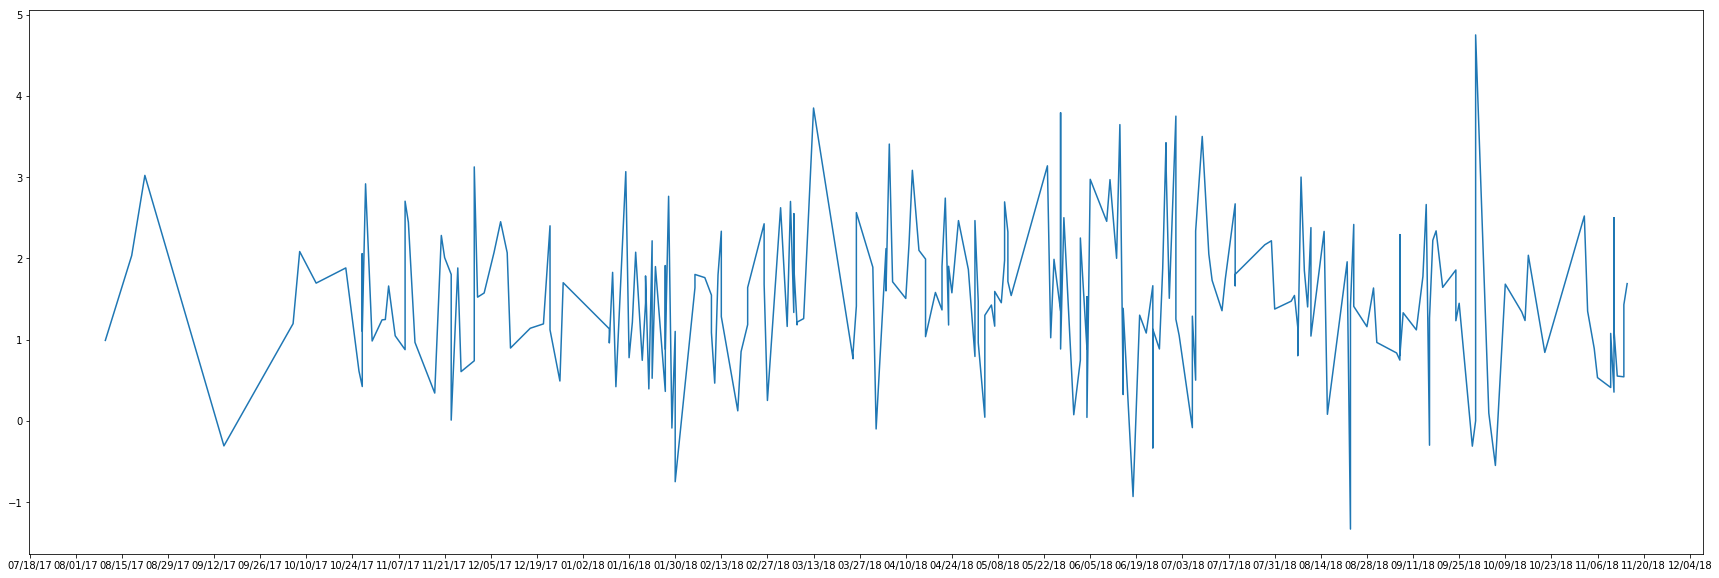

In [14]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(yelp_data['Date'],5*yelp_data['Sentiment'])
FMT = DateFormatter("%m/%d") 
ax.xaxis.set_major_formatter(FMT) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator( interval=2))

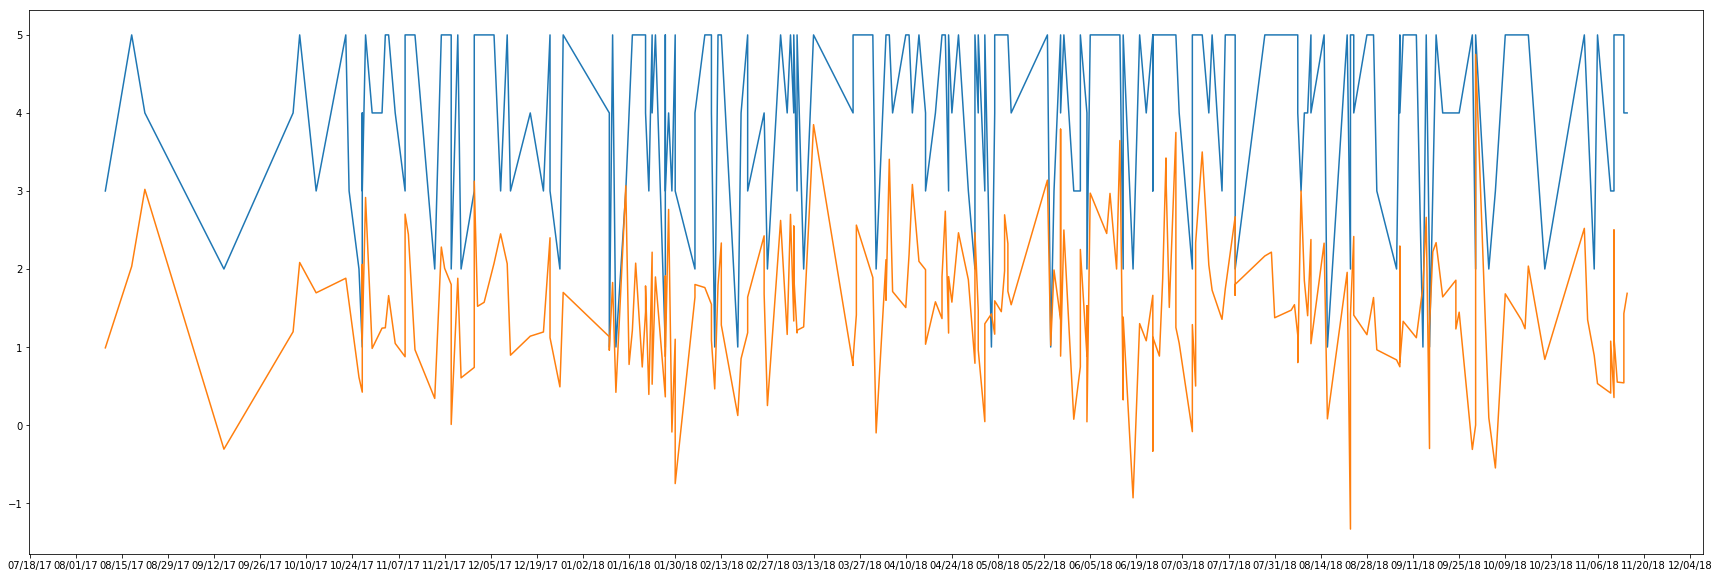

In [15]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(yelp_data['Date'],yelp_data['Rating'])
plt.plot(yelp_data['Date'],5*yelp_data['Sentiment'])
FMT = DateFormatter("%m/%d") 
ax.xaxis.set_major_formatter(FMT) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator( interval=2))

Here we group the data by date in order to use it in conjunction with the weather data. We average the ratings per day and eventually use it with the averaged temperatures per day.

In [16]:
groups = yelp_data.groupby(yelp_data['Date'])
yelp_data_ave_date = []
yelp_data_ave_rating = []
for i in yelp_data['Date'].unique():
    yelp_data_ave_date.append(i)
    yelp_data_ave_rating.append(np.mean(groups.get_group(i)['Rating']))

In [17]:
yelp_data_ave = pd.DataFrame({'Date': yelp_data_ave_date,'Average Rating':yelp_data_ave_rating})

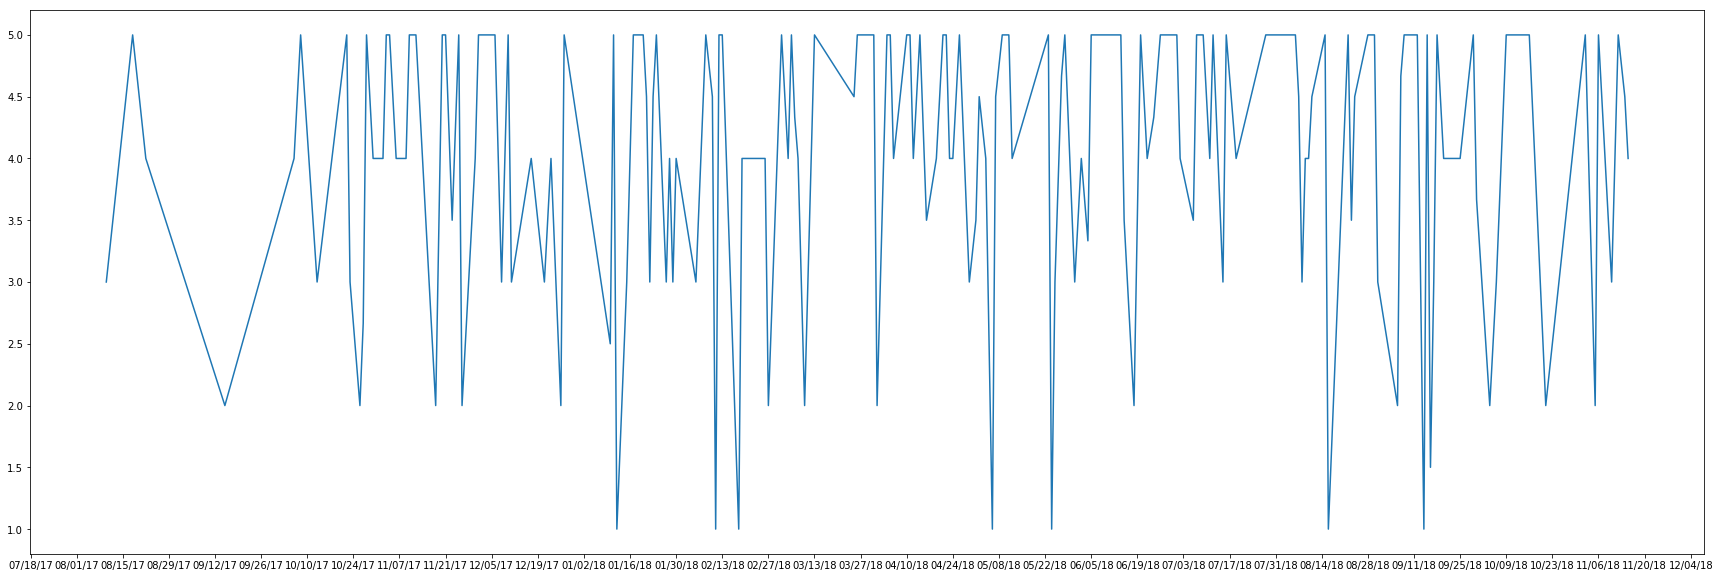

In [18]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(yelp_data_ave['Date'],yelp_data_ave['Average Rating'])
FMT = DateFormatter("%m/%d") 
ax.xaxis.set_major_formatter(FMT) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator( interval=2))

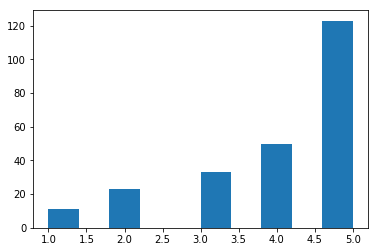

In [19]:
plt.hist(yelp_data['Rating'])
plt.show()

# Length of Review

In [20]:
def count(review):
    count = len(re.findall(r'\w+', review))
    return count
    
count_list = []
for review in yelp_data['Review']:
    count_list.append(count(review))
for count in count_list:
    yelp_data["Count"] = [i for i in count_list]
    
yelp_data.head()

Date  Rating                                             Review  \
0 2018-11-15     4.0  If second time is the charm then our dinner on...   
1 2018-11-14     4.0  Very good.  But I guess with all the hype, I w...   
2 2018-11-14     5.0  This has been on my bucket list for a while bu...   
3 2018-11-12     5.0  My boyfriend and I had an amazing experience a...   
4 2018-11-11     5.0  Ok where do I start I think if you reserved th...   

   Sentiment  Count  
0   0.337662    171  
1   0.285833     92  
2   0.108203    356  
3   0.110115    264  
4   0.224017    191

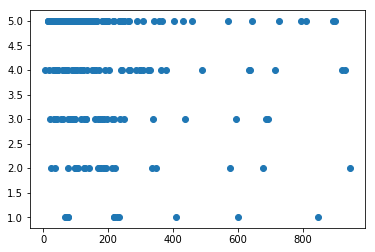

In [21]:
plt.scatter(yelp_data["Count"],yelp_data["Rating"])
plt.show()

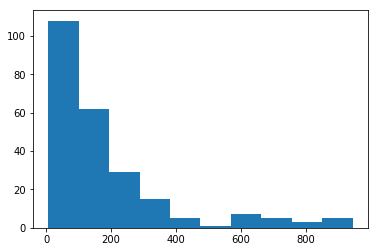

In [22]:
plt.hist(yelp_data["Count"])
plt.show()

# Weather Data Processing

In [23]:
df = pd.read_csv("owm09172017_09172018.csv")

In [24]:
acc=0
date_temp={}
acc=0
for i in range(0,len(df)-1):
    key = df["DATE"][i][0:10]
    temp = df["HOURLYDewPointTempC"][i]
    if (not math.isnan(temp)):
        if (key in date_temp):
            acc+=1
            date_temp[key].append(temp)
        else:
            acc=0
            date_temp[key] = [temp]

In [25]:
daily_ave_temp_c={}
for x in date_temp:
    daily_ave_temp_c[x]=np.mean(date_temp[x])

In [26]:
dictlist=[]
for key, value in daily_ave_temp_c.items():
    temp = [key,value]
    dictlist.append(temp)

In [27]:
new_df = pd.DataFrame(dictlist)
new_df[0]=pd.to_datetime(new_df[0])

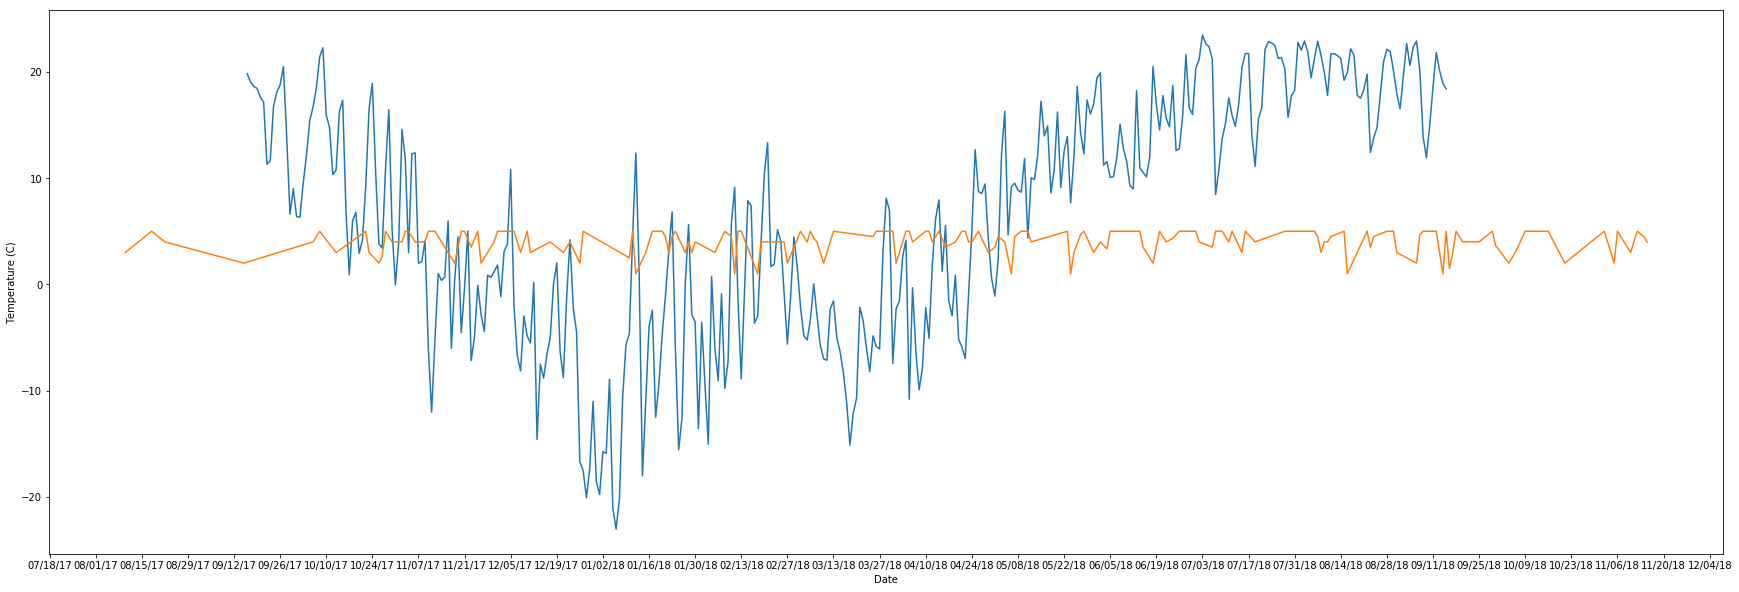

In [28]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(new_df[0],(new_df[1]),animated=True)
plt.plot(yelp_data_ave['Date'],(yelp_data_ave['Average Rating']))
ax.set(xlabel="Date", ylabel="Temperature (C)")
FMT = DateFormatter("%m/%d") 
ax.xaxis.set_major_formatter(FMT) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator( interval=2))

plt.show()

# Dataframe that joints Temperature into Yelp_Data by date


In [29]:
new_df.head(5)

0          1
0 2017-09-16  19.830769
1 2017-09-17  19.085714
2 2017-09-18  18.641667
3 2017-09-19  18.459375
4 2017-09-20  17.619444

In [30]:
new_df_dict = new_df.to_dict('records')

In [31]:
for x in new_df_dict:
    print(x)

{0: Timestamp('2017-09-16 00:00:00'), 1: 19.830769230769228}
{0: Timestamp('2017-09-17 00:00:00'), 1: 19.085714285714285}
{0: Timestamp('2017-09-18 00:00:00'), 1: 18.641666666666666}
{0: Timestamp('2017-09-19 00:00:00'), 1: 18.459375}
{0: Timestamp('2017-09-20 00:00:00'), 1: 17.61944444444445}
{0: Timestamp('2017-09-21 00:00:00'), 1: 17.162499999999998}
{0: Timestamp('2017-09-22 00:00:00'), 1: 11.316666666666668}
{0: Timestamp('2017-09-23 00:00:00'), 1: 11.665384615384616}
{0: Timestamp('2017-09-24 00:00:00'), 1: 16.754166666666666}
{0: Timestamp('2017-09-25 00:00:00'), 1: 18.108333333333334}
{0: Timestamp('2017-09-26 00:00:00'), 1: 18.765625}
{0: Timestamp('2017-09-27 00:00:00'), 1: 20.4969696969697}
{0: Timestamp('2017-09-28 00:00:00'), 1: 13.884848484848487}
{0: Timestamp('2017-09-29 00:00:00'), 1: 6.608333333333333}
{0: Timestamp('2017-09-30 00:00:00'), 1: 9.020512820512822}
{0: Timestamp('2017-10-01 00:00:00'), 1: 6.378571428571428}
{0: Timestamp('2017-10-02 00:00:00'), 1: 6.325}


{0: Timestamp('2018-07-09 00:00:00'), 1: 13.729166666666666}
{0: Timestamp('2018-07-10 00:00:00'), 1: 15.158333333333333}
{0: Timestamp('2018-07-11 00:00:00'), 1: 17.566666666666666}
{0: Timestamp('2018-07-12 00:00:00'), 1: 15.912121212121212}
{0: Timestamp('2018-07-13 00:00:00'), 1: 14.883333333333333}
{0: Timestamp('2018-07-14 00:00:00'), 1: 16.900000000000002}
{0: Timestamp('2018-07-15 00:00:00'), 1: 20.37777777777778}
{0: Timestamp('2018-07-16 00:00:00'), 1: 21.729166666666668}
{0: Timestamp('2018-07-17 00:00:00'), 1: 21.744444444444447}
{0: Timestamp('2018-07-18 00:00:00'), 1: 14.0625}
{0: Timestamp('2018-07-19 00:00:00'), 1: 11.104166666666666}
{0: Timestamp('2018-07-20 00:00:00'), 1: 15.575000000000001}
{0: Timestamp('2018-07-21 00:00:00'), 1: 16.61891891891892}
{0: Timestamp('2018-07-22 00:00:00'), 1: 22.13018867924528}
{0: Timestamp('2018-07-23 00:00:00'), 1: 22.852631578947367}
{0: Timestamp('2018-07-24 00:00:00'), 1: 22.736666666666657}
{0: Timestamp('2018-07-25 00:00:00'), 

In [32]:
yelp_data.head(5)

Date  Rating                                             Review  \
0 2018-11-15     4.0  If second time is the charm then our dinner on...   
1 2018-11-14     4.0  Very good.  But I guess with all the hype, I w...   
2 2018-11-14     5.0  This has been on my bucket list for a while bu...   
3 2018-11-12     5.0  My boyfriend and I had an amazing experience a...   
4 2018-11-11     5.0  Ok where do I start I think if you reserved th...   

   Sentiment  Count  
0   0.337662    171  
1   0.285833     92  
2   0.108203    356  
3   0.110115    264  
4   0.224017    191

In [33]:
temp_lst=[]
for date in yelp_data['Date']:
    switch = True
    for x in new_df_dict:
        if x[0] == date:
            temp_lst.append(x[1])
            switch = False
    if switch:
        temp_lst.append(x[1])


In [34]:
yelp_data["Temp"] = [x for x in temp_lst]

In [35]:
yelp_data.head(20)

Date  Rating                                             Review  \
0  2018-11-15     4.0  If second time is the charm then our dinner on...   
1  2018-11-14     4.0  Very good.  But I guess with all the hype, I w...   
2  2018-11-14     5.0  This has been on my bucket list for a while bu...   
3  2018-11-12     5.0  My boyfriend and I had an amazing experience a...   
4  2018-11-11     5.0  Ok where do I start I think if you reserved th...   
5  2018-11-11     4.0  Outstanding dining experience at Eleven Madiso...   
6  2018-11-11     3.0  The food other than the dessert was mostly gre...   
7  2018-11-10     3.0  Ok, if this was just another regular ole resta...   
8  2018-11-10     3.0  Disappointing. Can't believe this was #1 (and ...   
9  2018-11-06     5.0  Loved came with a hot escort and had champagne...   
10 2018-11-05     2.0  Was treated to a meal here by a friend and the...   
11 2018-11-03     4.0  I had lunch here in July, it was my third time...   
12 2018-11-02     5.0  I came here for a birthday dinner and everythi...   
13 2018-10-21     2.0  Me and my wife travel a lot and have been to m...   
14 2018-10-16     5.0  Eleven Madison park has now become my favorite...   
15 2018-10-15     5.0  From our experience at my recent 21st wed anni...   
16 2018-10-14     5.0  EMP had been on our radar for several years an...   
17 2018-10-09     5.0  Eleven Madison Park was on my friend's bucket ...   
18 2018-10-06     3.0  Overrated! Every dish is over salted, and they...   
19 2018-10-04     2.0  I've been holding off on writing this review a...   

    Sentiment  Count       Temp  
0    0.337662    171  18.406667  
1    0.285833     92  18.406667  
2    0.108203    356  18.406667  
3    0.110115    264  18.406667  
4    0.224017    191  18.406667  
5    0.500000      7  18.406667  
6    0.070536     95  18.406667  
7    0.215085    238  18.406667  
8    0.081944    132  18.406667  
9    0.106250     26  18.406667  
10   0.178132    575  18.406667  
11   0.269792     61  18.406667  
12   0.504167     66  18.406667  
13   0.168333    102  18.406667  
14   0.407476    235  18.406667  
15   0.246875     55  18.406667  
16   0.267964    244  18.406667  
17   0.336352    793  18.406667  
18  -0.110000     37  18.406667  
19   0.018839    222  18.406667

# Statistics about Reviews

In [36]:
# Mean of all ratings
yelp_raings = np.array([float(i) for i in yelp_data['Rating']])

In [37]:
np.mean(yelp_raings)

4.045833333333333

In [38]:
np.std(yelp_raings)

1.2015542596524258

In [39]:
def normal(x, mean, std_dev):
    result = 1.0 / (std_dev * np.sqrt(2 * np.pi))
    result *= np.exp(-(x - mean)**2/ (2*std_dev**2))
    return result

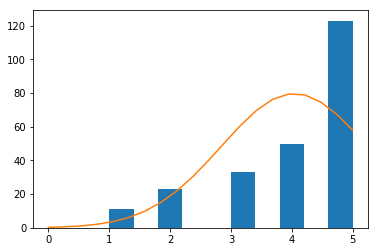

In [40]:
x = np.linspace(0, 5, 20)
plt.hist(yelp_raings)
plt.plot(x, 240*normal(x, 4.04, 1.201))
plt.show()

The rating distribution has mostly biases towards 5 starts.
And it is sensible in that these reviews are collected from EMP, which is Michelin 3 star restaurants that has been rated the best all the best. Therefore, it is expected that its ratings do not necessarily for a normal distribution. 

In [41]:
yelp_sent = np.array([float(i) for i in yelp_data['Sentiment']])

In [42]:
np.mean(yelp_sent)

0.30162550477721317

In [43]:
np.std(yelp_sent)

0.183837990789535

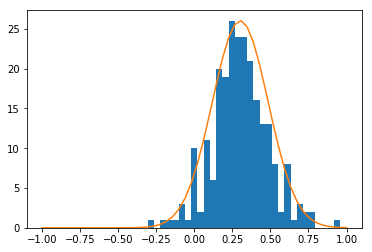

In [44]:
x_1 = np.linspace(-1, 1)
plt.hist(yelp_sent, bins=np.linspace(-1,1))
plt.plot(x_1, 12*normal(x_1, 0.3016, 0.1838799))
plt.show()

Interestingly, the sentiment analysis distribution looks pretty close to normal. It is not quite intuitive though, since we indeed could notice some correlation from the graph above which plots both Rating and Sentiment with respect to Date. 

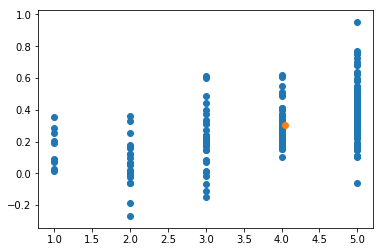

In [45]:
plt.scatter(yelp_raings, yelp_sent) # the x_0, x_1 pairs in blue
plt.scatter(np.mean(yelp_raings), np.mean(yelp_sent) )# the mean in green
plt.show()

In [46]:
# first, let's calculate the variance of the two dimensions.
#  the `ddof=1` argument means divide by (n-1) instead of n.
# it's around 1, which is good since these values are from
#  a normal with variance 1, and sample size 100.
yelp_raings.var(ddof=1)

1.4497733612273362

In [47]:
# same with the second column. this one is quite close to 1.0.
yelp_sent.var(ddof=1)

0.033937814417606516

In [48]:
np.corrcoef(yelp_raings,yelp_sent)

array([[1.        , 0.54933637],
       [0.54933637, 1.        ]])

In [49]:
np.cov(yelp_raings,yelp_sent)

array([[1.44977336, 0.12185135],
       [0.12185135, 0.03393781]])

Correlation coefficient is more well-behaved. Here we get a correlation of 0.549, which is pretty large for such variable data.

## Weather and Rating Stats

In [50]:
temp = np.array(yelp_data['Temp'])

In [51]:
temp.mean()

8.543014652436481

In [52]:
temp.var()

101.05716238879263

In [53]:
temp.std()

10.052719153979814

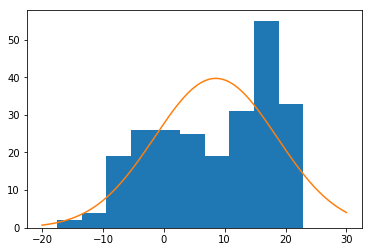

In [54]:
x = np.linspace(-20, 30, 200)
plt.hist(temp)
plt.plot(x, 1000*normal(x, 8.54, 10.0527))
plt.show()

In [55]:
np.cov(yelp_data['Rating'],yelp_data['Temp'])

array([[  1.44977336,   0.16392698],
       [  0.16392698, 101.4799957 ]])

In [56]:
np.corrcoef(yelp_data['Rating'],yelp_data['Temp'])

array([[1.        , 0.01351482],
       [0.01351482, 1.        ]])

In [57]:
def get_linear_model(x, y):
    x_mean = x.mean()
    y_mean = y.mean()
    sum_x_squared = np.sum((x - x_mean)**2)
    sum_y_squared = np.sum((y - y_mean)**2)
    sum_x_y = np.sum((x - x_mean) * (y - y_mean))
    
    slope = sum_x_y / sum_x_squared
    intercept = y_mean - x_mean * slope

    predictions = x * slope + intercept
    sum_squared_error = np.sum((y - predictions)**2)
    standard_error = np.sqrt(sum_squared_error / ((len(x) - 2) * sum_x_squared))
    
    return { "slope": slope, "intercept": intercept, "standard_error": standard_error }
def predict(x, model):
    return x * model["slope"] + model["intercept"]

In [58]:
model = get_linear_model(temp, yelp_raings)
print(model) 

{'slope': 0.001615362476774182, 'intercept': 4.0320332680252555, 'standard_error': 0.007746966778070541}


In [59]:
x_extent = np.array([temp.min(), temp.max()])
print(predict(x_extent, model))

[4.00368366 4.06905536]


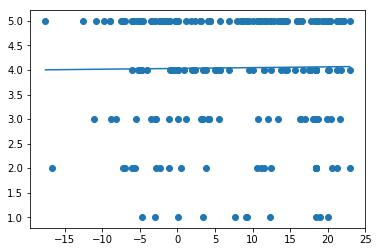

In [60]:
plt.scatter(temp, yelp_raings)
plt.plot( x_extent, predict(x_extent, model) )
plt.show()

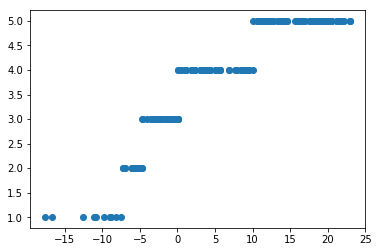

In [61]:
plt.scatter(np.sort(temp), np.sort(yelp_raings))
plt.show()

After calculating and plotting out temperature data and reviews, we pretty much can conclude that temperature does not necessarily have an effect on how people enjoy their dinner at EMP. However, we are exploring this in a more general scope in order to better sense a potential correlation between weather and yelp reviews. That being said, we believe it would make sense if we take reviews from other restaurants into consideration and compare all those average ratings with temperatures. 

# More Restaurants

In [194]:
# Reviews
# This is the reviews for Upstate
urls = []
c = 200
for i in range(25): 
    new = "https://www.yelp.com/biz/boucherie-west-village-new-york-3?start="+str(c)+"&sort_by=date_desc"
    urls.append(new)
    c+=20
Reviews_mad = []
for url in urls:
    html = urlopen(url)
    bsObj4 = BeautifulSoup(html)
   
    reviewers = bsObj4.find_all('div', {'itemprop': 'review'})
    for name in reviewers:
        Reviews_mad.append(name.get_text())

In [195]:
date_mad = []
Ratings_mad = []
for url in urls:
    html = urlopen(url)
    bsObj4 = BeautifulSoup(html)
    for name in bsObj4.find_all('meta', {'itemprop': 'datePublished'}):
        date_mad.append(name.get("content"))
    for reviewBody in bsObj4.findAll('div',{"class":"review-content"}):
        Ratings_mad.append(reviewBody.div.div.div.get("title"))


In [196]:
yelp_data_upstate = pd.DataFrame({'Review': Reviews_mad,'Rating':Ratings_mad, 'Date': date_mad})
yelp_data_upstate['Review'] = [i.replace('\n', '') for i in yelp_data_upstate['Review']]
yelp_data_upstate['Rating'] = [float(re.sub(r'[^\d.]+','', i)) for i in yelp_data_upstate['Rating']]
yelp_data_upstate["Date"] = [pd.to_datetime(i) for i in yelp_data_upstate["Date"]]

temp_lst=[]
for date in yelp_data_upstate['Date']:
    switch = True
    for x in new_df_dict:
        if x[0] == date:
            temp_lst.append(x[1])
            switch = False
    if switch:
        temp_lst.append(x[1])
yelp_data_upstate["Temp"] = [x for x in temp_lst]

In [198]:
yelp_data_upstate.head(20)

Date  Rating                                             Review  \
0  2018-11-25     4.0  Great service, food was good but not as amazin...   
1  2018-11-18     1.0  The deliciousness of the food is overshadowed ...   
2  2018-11-18     5.0  Beautiful setting. Beautiful view. Food is del...   
3  2018-11-17     5.0  I was invited to come back to give Boucherie a...   
4  2018-11-16     5.0  Mama MiA this burger is really good. They have...   
5  2018-11-15     5.0  Went for our anniversary, steak frites and Esc...   
6  2018-11-14     4.0  Located in West Village, Boucherie restaurant ...   
7  2018-11-13     2.0  While the food at Boucherie is good, I would n...   
8  2018-11-13     3.0  Excellent food, good service, questionable man...   
9  2018-11-11     5.0  Excellent service and food! Showed up at the w...   
10 2018-11-10     4.0  Perfect place for dinner near NYU and Washingt...   
11 2018-11-09     3.0  Good vibes but food is okay. Too greasy for my...   
12 2018-11-09     5.0  Came here late on a Friday night with a friend...   
13 2018-11-08     5.0  Never ate at a French restaurant before so dec...   
14 2018-11-08     5.0  Writing an update to my previous review.  To b...   
15 2018-11-07     5.0  "Boucherie" means "butchery" in French, so my ...   
16 2018-11-06     5.0  Perfect date night / post- workday dinner spot...   
17 2018-11-04     5.0  I liked this place, love the French decor, giv...   
18 2018-11-04     4.0  Ended up at Boucherie unexpectedly after a cha...   
19 2018-11-04     5.0  We had a 7pm res for a party of 11 for a Birth...   

         Temp  
0   18.406667  
1   18.406667  
2   18.406667  
3   18.406667  
4   18.406667  
5   18.406667  
6   18.406667  
7   18.406667  
8   18.406667  
9   18.406667  
10  18.406667  
11  18.406667  
12  18.406667  
13  18.406667  
14  18.406667  
15  18.406667  
16  18.406667  
17  18.406667  
18  18.406667  
19  18.406667

In [199]:
sentiment_list_upstate = []
for review in yelp_data_upstate['Review']:
    sentiment_list_upstate.append(review_sentiment(review))
for sent in sentiment_list:
    yelp_data_upstate["Sentiment"] = [i for i in sentiment_list_upstate]

In [200]:
yelp_data_upstate.to_csv("yelp_data_boucherie.csv")
yelp_data_upstate.head(5)


Date  Rating                                             Review  \
0 2018-11-25     4.0  Great service, food was good but not as amazin...   
1 2018-11-18     1.0  The deliciousness of the food is overshadowed ...   
2 2018-11-18     5.0  Beautiful setting. Beautiful view. Food is del...   
3 2018-11-17     5.0  I was invited to come back to give Boucherie a...   
4 2018-11-16     5.0  Mama MiA this burger is really good. They have...   

        Temp  Sentiment  
0  18.406667   0.168389  
1  18.406667   0.725000  
2  18.406667   0.535625  
3  18.406667   0.345084  
4  18.406667   0.340000

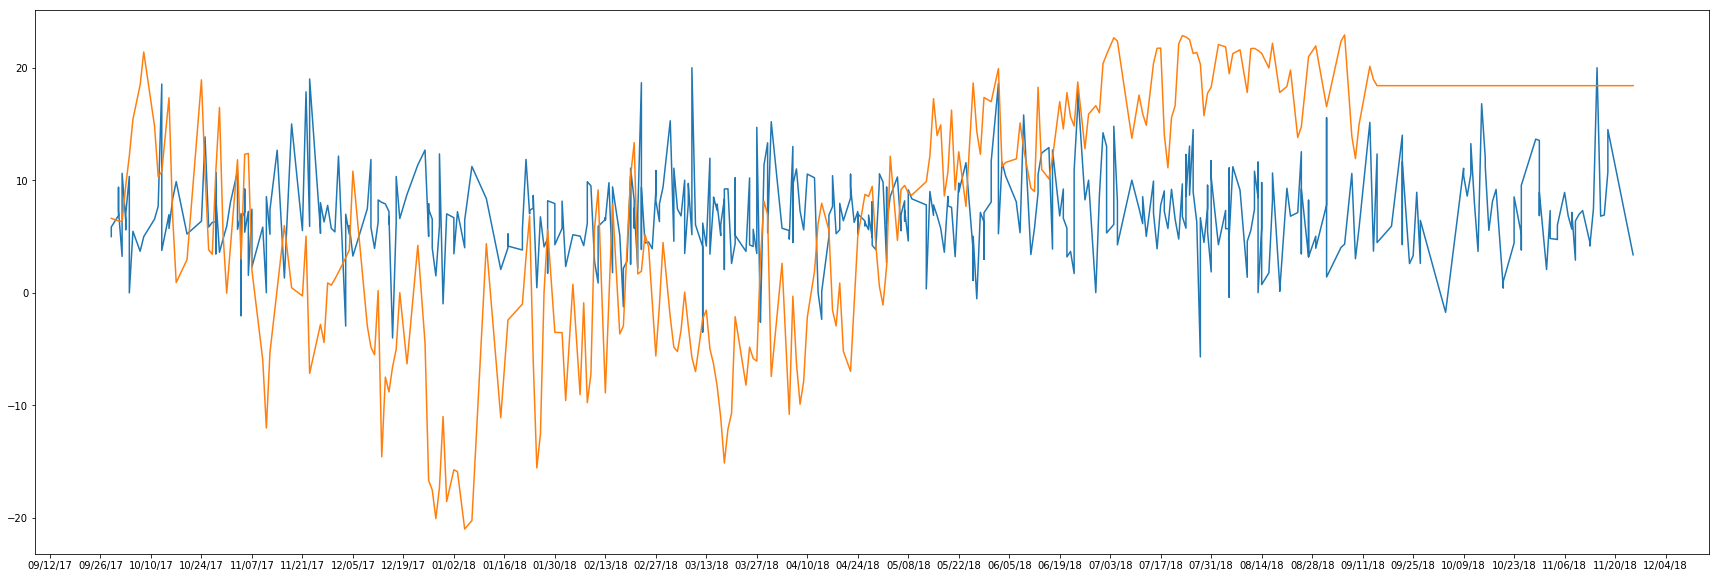

In [201]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(yelp_data_upstate['Date'],20*yelp_data_upstate['Sentiment'])
plt.plot(yelp_data_upstate['Date'],yelp_data_upstate['Temp'])
FMT = DateFormatter("%m/%d") 
ax.xaxis.set_major_formatter(FMT) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator( interval=2))

In [202]:
yelp_data_upstate = yelp_data_upstate[ yelp_data_upstate["Date"] > "2017-08-10" ]
yelp_data_upstate = yelp_data_upstate[ yelp_data_upstate["Date"] < "2018-07-10" ]
yelp_data_upstate.sort_values("Date")


Date  Rating                                             Review  \
499 2017-09-29     5.0  Came back here to try Boucherie again, at the ...   
498 2017-09-29     5.0  Visited for the 1st time since opening night. ...   
496 2017-10-01     5.0  Went here for brunch with some friends and my ...   
497 2017-10-01     5.0  Boucherie is an authentic French restaurant wi...   
495 2017-10-01     5.0  A stellar meal at Boucherie on a Saturday nigh...   
492 2017-10-02     5.0  i had an opportunity to eat here again & we we...   
494 2017-10-02     2.0  I first discovered Boucherie via their beautif...   
493 2017-10-02     4.0  Ordered the duck confit, which I really enjoye...   
489 2017-10-03     5.0  This place rocks!! I went to meet coworkers fo...   
491 2017-10-03     5.0  Came here with a friend for dinner last night....   
490 2017-10-03     5.0  This place feels like we are in France!We came...   
488 2017-10-04     5.0  Boucherie is a wonderful French restaurant loc...   
487 2017-10-04     2.0  Was very excited for this restaurant, love Fre...   
486 2017-10-05     4.0  After my prior review, which was less than ste...   
485 2017-10-07     5.0  Several very amazing things happened here when...   
484 2017-10-08     5.0  As the French would say, everything was parfai...   
483 2017-10-11     4.0  The decor of this place is gorgeous! It is a p...   
482 2017-10-12     5.0  I've always passed by this restaurant, so I wa...   
481 2017-10-13     5.0  Awesome place. Great drinks and excellent atmo...   
480 2017-10-13     4.0  This place is beautiful, classy and romantic, ...   
479 2017-10-15     5.0  UPDATE- October 14,2017. We were invited back ...   
478 2017-10-15     5.0  So after my unfortunate experience, I was cont...   
477 2017-10-16     5.0  After an amazing dining experience at Olio e P...   
476 2017-10-17     5.0  That was one of our favorite meals while worki...   
475 2017-10-20     5.0  We came to Boucherie for dinner last weekend, ...   
474 2017-10-24     5.0  Boucherie is a charming restaurant in the hear...   
473 2017-10-25     5.0  I went for a couple of drinks with my boyfrien...   
472 2017-10-26     5.0  I didn't have a high expectation walking into ...   
471 2017-10-27     4.0  Loved the atmosphere, went there to catch up w...   
470 2017-10-28     3.0  Overall: solid restaurant and experience, but ...   
..         ...     ...                                                ...   
176 2018-06-13     5.0  Absolutely love this restaurant. The setting i...   
175 2018-06-14     5.0  Delicious food, great atmosphere and superb se...   
174 2018-06-16     5.0  Love this! Good escargot and duck confit. Nice...   
173 2018-06-17     4.0  The service here is phenomenal- dishes are tim...   
172 2018-06-17     4.0  It's Fathers Day...  I have been coming to Bou...   
171 2018-06-17     4.0  We had a pretty good experience at the restaur...   
170 2018-06-19     4.0  Upon my recent return, It lives up to it's nam...   
168 2018-06-20     4.0  The place is great for the spring summer with ...   
169 2018-06-20     5.0  Last month, my friend and I dined at Boucherie...   
167 2018-06-21     5.0  A + Z = Amazing!This was my first time at Bouc...   
166 2018-06-21     5.0  I came here a few weeks ago and had a sub par ...   
165 2018-06-22     5.0  The food here was really good and so were the ...   
164 2018-06-23     2.0  The service was very good but slow because the...   
163 2018-06-23     4.0  After a recent Yelp Elite event at their newer...   
162 2018-06-24     5.0  One of the best places for food drinks and ser...   
161 2018-06-24     5.0  Ask for waiter Dado. He was the best. Loved hi...   
160 2018-06-26     5.0  Food was very French and very good! Escargot, ...   
159 2018-06-27     5.0  Absolutely loved this place.  Had so much fun ...   
158 2018-06-29     1.0  20 minutes and no server ever stopped by the t...   
157 2018-06-30     4.0  Great new place to go in the village, if You h...   
156 20

In [203]:
yelp_data = yelp_data[ yelp_data["Date"] > "2017-08-10" ]
yelp_data = yelp_data[ yelp_data["Date"] < "2018-07-10" ]
yelp_data.sort_values("Date")

Date  Rating                                             Review  \
238 2017-08-18     5.0  Professional as can be. Felt like a king being...   
237 2017-08-22     4.0  Delicious food and great service!! We went the...   
236 2017-09-15     2.0  April 23, 201712:00 PM4 GuestsMaybe an off nig...   
235 2017-10-06     4.0  The restaurant, designed by Bentel & Bentel, i...   
234 2017-10-08     5.0  Went there for hubbys  date night and was surp...   
233 2017-10-13     3.0  I have been super excited to try EMP, especial...   
232 2017-10-22     5.0  Impeccable dining experience at the world no. ...   
231 2017-10-23     3.0  I came here to celebrate my birthday.  The spa...   
230 2017-10-26     2.0  Overall very disappointing. when you wait at t...   
229 2017-10-27     1.0  Thoroughly unimpressed.  The service was atten...   
228 2017-10-27     4.0  I had been several years ago and was a bit und...   
227 2017-10-27     3.0  EMP (bar experience) was very disappointing.  ...   
226 2017-10-28     5.0  It earns its title as the best restaurant in t...   
225 2017-10-30     4.0  I came to EMP on my first trip to NYC, to cele...   
224 2017-11-02     4.0  Honest review from a personal point of view is...   
223 2017-11-03     5.0  This restaurant needs no introduction, nor doe...   
222 2017-11-04     5.0  Currently, this is the best restaurant I have ...   
221 2017-11-06     4.0  I can't believe I'm giving "The Best Restauran...   
220 2017-11-09     3.0  Have you ever walked away from a restaurant di...   
219 2017-11-09     5.0  Excellent. 10/10 I loved everything about my e...   
218 2017-11-10     5.0  The hotel has been beautifully updated and the...   
217 2017-11-12     5.0  We made it in for the first time before EMP cl...   
216 2017-11-18     2.0  We're waiting for our Uber, having just had my...   
215 2017-11-20     5.0  Best food and service stuff. Everything that I...   
214 2017-11-21     5.0  I find it a bit ridiculous that I'm writing a ...   
213 2017-11-23     5.0  Such an amazing experience!  I've been a few 3...   
212 2017-11-23     2.0  What a huge disappointment. My wife and I are ...   
211 2017-11-25     5.0  This was one of the best meals I have had in a...   
210 2017-11-26     2.0  Really? This restaurant is supposed to be numb...   
209 2017-11-30     3.0  The anticipation is better than the actual exp...   
..         ...     ...                                                ...   
99  2018-06-02     3.0  Eleven Madison Park pre-renovation used to be ...   
97  2018-06-04     4.0  2 star food, 3 star service, 4 star pricingI b...   
96  2018-06-04     4.0  Truly lived up to all the hype. Almost everyth...   
95  2018-06-04     2.0  Bland, everything about this restaurant is bla...   
94  2018-06-05     5.0  Went for a drink in the bar/lounge area tonigh...   
93  2018-06-10     5.0  We dined at EMP tonight to celebrate a birthda...   
92  2018-06-11     5.0  I was there in 2016 and it was my first three ...   
91  2018-06-13     5.0  There isn't much more that can be added - Elev...   
90  2018-06-14     5.0  Best dining experience!! 5 star service from b...   
88  2018-06-15     5.0  The spring/summer menu heavily features season...   
89  2018-06-15     2.0  After 4+ years of living in New York and count...   
87  2018-06-18     2.0  Finally we have decided to try out this claime...   
86  2018-06-20     5.0  Wow wow wow, what a place. The food is out of ...   
85  2018-06-22     4.0  This place has plenty of people who work here....   
84  2018-06-24     5.0  In one word. Perfection. I was surprised with ...   
83  2018-06-24     3.0  Every dish was too salty for me, even the ice ...   
82  2018-06-24     5.0  So hard to get into, but so worth the drama an...   
81  2018-06-26     5.0  My wife and I had the Dining Room Tasting Menu...   
80  2018-06-27     5.0  This place has amazing service and food that a...   
78  2018-06-28     5.0  Ethereal.  Have the good fortune to have been ...   
79  20

In [204]:
merged = pd.merge(yelp_data,yelp_data_upstate,left_on='Date',right_on='Date')

In [205]:
merged.head(5)

Date  Rating_x                                           Review_x  \
0 2018-07-09       5.0  Great place to enjoy great company with excell...   
1 2018-07-02       4.0  We came here for dinner this past weekend. It ...   
2 2018-07-02       4.0  We came here for dinner this past weekend. It ...   
3 2018-07-02       4.0  We came here for dinner this past weekend. It ...   
4 2018-07-01       5.0  Definitely deserving of all three stars. Staff...   

   Sentiment_x  Count     Temp_x  NBC_sentiment  Rating_y  \
0     0.700000     16  13.729167      13.932368       5.0   
1     0.209888    299  21.183333      25.162588       5.0   
2     0.209888    299  21.183333      25.162588       3.0   
3     0.209888    299  21.183333      25.162588       5.0   
4     0.250000     36  20.358333      10.276594       5.0   

                                            Review_y     Temp_y  Sentiment_y  
0  Pricey, but excellent food and service. The dr...  13.729167     0.500000  
1  Regarding my experience in Boucherie I can say...  21.183333     0.265509  
2  Was ok, but not mind blowing. But it is really...  21.183333     0.400000  
3  One of the best meals I've ever had in NYC.  S...  21.183333     0.650000  
4  Great coffee! Wonderful patisserie and of cour...  20.358333     0.711111

In [206]:
merged['Ave'] = (merged['Sentiment_x']+merged['Sentiment_y'])/2
merged['Ave_R'] = (merged['Rating_x']+merged['Rating_y'])/2

In [207]:
merged.head(5)

Date  Rating_x                                           Review_x  \
0 2018-07-09       5.0  Great place to enjoy great company with excell...   
1 2018-07-02       4.0  We came here for dinner this past weekend. It ...   
2 2018-07-02       4.0  We came here for dinner this past weekend. It ...   
3 2018-07-02       4.0  We came here for dinner this past weekend. It ...   
4 2018-07-01       5.0  Definitely deserving of all three stars. Staff...   

   Sentiment_x  Count     Temp_x  NBC_sentiment  Rating_y  \
0     0.700000     16  13.729167      13.932368       5.0   
1     0.209888    299  21.183333      25.162588       5.0   
2     0.209888    299  21.183333      25.162588       3.0   
3     0.209888    299  21.183333      25.162588       5.0   
4     0.250000     36  20.358333      10.276594       5.0   

                                            Review_y     Temp_y  Sentiment_y  \
0  Pricey, but excellent food and service. The dr...  13.729167     0.500000   
1  Regarding my experience in Boucherie I can say...  21.183333     0.265509   
2  Was ok, but not mind blowing. But it is really...  21.183333     0.400000   
3  One of the best meals I've ever had in NYC.  S...  21.183333     0.650000   
4  Great coffee! Wonderful patisserie and of cour...  20.358333     0.711111   

        Ave  Ave_R  
0  0.600000    5.0  
1  0.237698    4.5  
2  0.304944    3.5  
3  0.429944    4.5  
4  0.480556    5.0

In [208]:
merged["Ave"] = minmax_scaling(merged["Ave"], columns = [0])
merged["Ave_R"] = minmax_scaling(merged["Ave_R"], columns = [0])
merged["Temp_x"] = minmax_scaling(merged["Temp_x"], columns = [0])

In [209]:
merged.head(100)

Date  Rating_x                                           Review_x  \
0  2018-07-09       5.0  Great place to enjoy great company with excell...   
1  2018-07-02       4.0  We came here for dinner this past weekend. It ...   
2  2018-07-02       4.0  We came here for dinner this past weekend. It ...   
3  2018-07-02       4.0  We came here for dinner this past weekend. It ...   
4  2018-07-01       5.0  Definitely deserving of all three stars. Staff...   
5  2018-07-01       5.0  Excellent food and service without a strict dr...   
6  2018-06-29       5.0  I have been fortunate enough to dine at Eleven...   
7  2018-06-27       5.0  This place has amazing service and food that a...   
8  2018-06-26       5.0  My wife and I had the Dining Room Tasting Menu...   
9  2018-06-24       5.0  So hard to get into, but so worth the drama an...   
10 2018-06-24       5.0  So hard to get into, but so worth the drama an...   
11 2018-06-24       3.0  Every dish was too salty for me, even the ice ...   
12 2018-06-24       3.0  Every dish was too salty for me, even the ice ...   
13 2018-06-24       5.0  In one word. Perfection. I was surprised with ...   
14 2018-06-24       5.0  In one word. Perfection. I was surprised with ...   
15 2018-06-22       4.0  This place has plenty of people who work here....   
16 2018-06-20       5.0  Wow wow wow, what a place. The food is out of ...   
17 2018-06-20       5.0  Wow wow wow, what a place. The food is out of ...   
18 2018-06-14       5.0  Best dining experience!! 5 star service from b...   
19 2018-06-13       5.0  There isn't much more that can be added - Elev...   
20 2018-06-13       5.0  There isn't much more that can be added - Elev...   
21 2018-06-11       5.0  I was there in 2016 and it was my first three ...   
22 2018-06-04       2.0  Bland, everything about this restaurant is bla...   
23 2018-06-04       4.0  Truly lived up to all the hype. Almost everyth...   
24 2018-06-04       4.0  2 star food, 3 star service, 4 star pricingI b...   
25 2018-06-02       5.0  Fabulous fabulous dinner! We went there with m...   
26 2018-06-02       5.0  Fabulous fabulous dinner! We went there with m...   
27 2018-06-02       5.0  Fabulous fabulous dinner! We went there with m...   
28 2018-06-02       3.0  Eleven Madison Park pre-renovation used to be ...   
29 2018-06-02       3.0  Eleven Madison Park pre-renovation used to be ...   
..        ...       ...                                                ...   
70 2018-04-19       4.0  The first time we went to EMP last year (short...   
71 2018-04-19       4.0  The first time we went to EMP last year (short...   
72 2018-04-16       3.0  We had a lovely time. Staff was beyond friendl...   
73 2018-04-16       3.0  We had a lovely time. Staff was beyond friendl...   
74 2018-04-16       4.0  Servers and hosts were amazing and personable....   
75 2018-04-16       4.0  Servers and hosts were amazing and personable....   
76 2018-04-14       5.0  Pretty expensive but how delicious! This place...   
77 2018-04-14       5.0  Pretty expensive but how delicious! This place...   
78 2018-04-12       4.0  Took my fiancé for her birthday and let me jus...   
79 2018-04-10       5.0  A truly special experience and one of the best...   
80 2018-04-06       4.0  Great Michelin 3-star restaurant. My family an...   
81 2018-04-06       4.0  Great Michelin 3-star restaurant. My family an...   
82 2018-04-06       4.0  Great Michelin 3-star restaurant. My family an...   
83 2018-04-05       5.0  What a fun experience! We came here for our an...   
84 2018-04-05       5.0  What a fun experience! We came here for our an...   
85 2018-03-31       5.0  Contemporary American restaurant. Favorite dis...   
86 2018-03-26       5.0  We went here for lunch.  It was an unique dini...   
87 2018-03-26       5.0  We went here for lunch.  It was an unique dini...   
88 2018-03-26       5.0  Hands down best 3 star restaurant I've been to...   
89 2018-03-26       5.0  Hands 

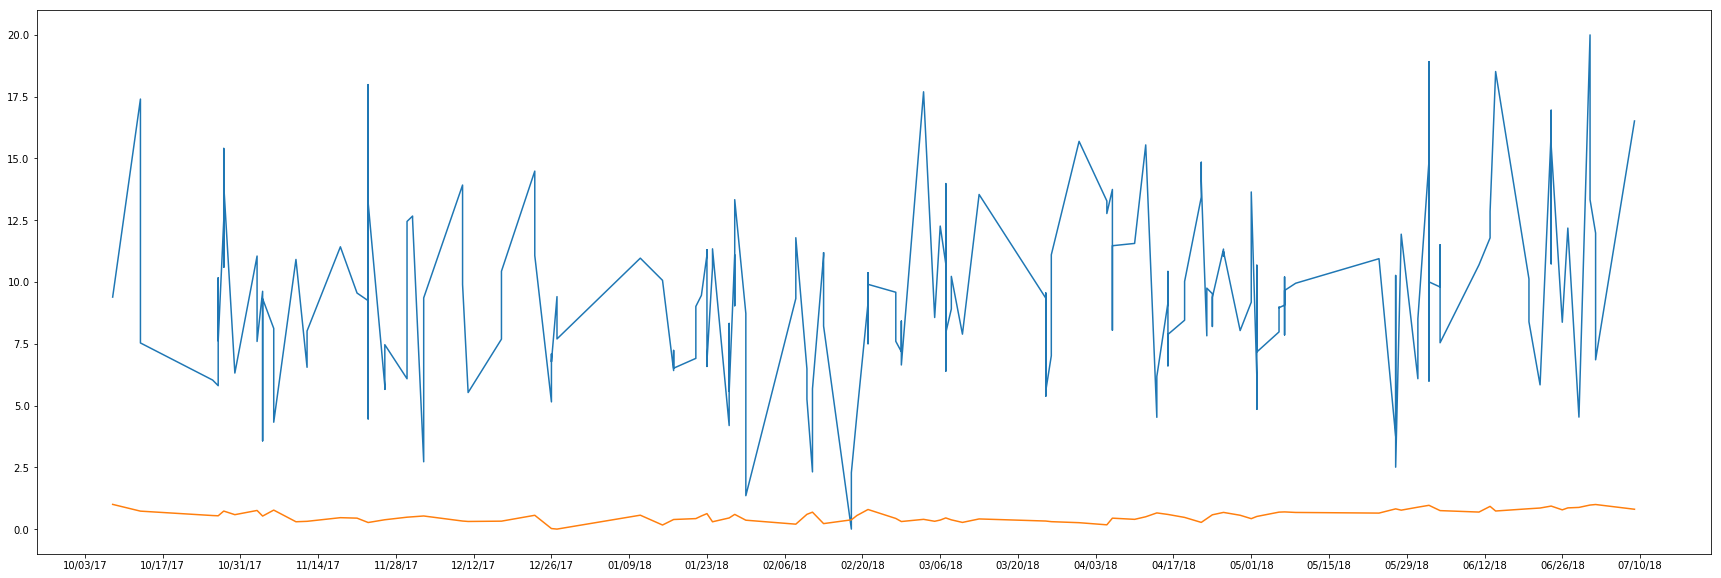

In [210]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(merged['Date'],20*merged['Ave'])
plt.plot(merged['Date'],merged['Temp_x'])
FMT = DateFormatter("%m/%d") 
ax.xaxis.set_major_formatter(FMT) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator( interval=2))

# Linear Regression

In [211]:
rating_sentiment_model = LinearRegression().fit(yelp_data["Rating"].values.reshape(-1, 1),
                                    yelp_data["Sentiment"]) 

In [212]:
rating_sentiment_model.coef_

array([0.09201159])

In [213]:
rating_sentiment_model_merged = LinearRegression().fit(merged["Ave_R"].values.reshape(-1, 1),
                          
                                                       merged["Ave"]) 

In [214]:
rating_sentiment_model_merged.coef_

array([0.47295148])

In [215]:
rating_temp_model = LinearRegression().fit(yelp_data["Temp"].values.reshape(-1, 1),
                                    yelp_data["Rating"]) 

In [216]:
rating_temp_model.coef_

array([0.00559284])

In [217]:
sentiment_temp_model = LinearRegression().fit(yelp_data["Temp"].values.reshape(-1, 1),
                                    yelp_data["Sentiment"]) 

In [218]:
sentiment_temp_model.coef_

array([3.10163661e-05])

In [219]:
rating_temp_model_merged = LinearRegression().fit(merged["Temp_x"].values.reshape(-1, 1),
                                    merged["Ave_R"]) 

In [220]:
rating_temp_model_merged.coef_

array([0.0111727])

In [221]:
sentiment_temp_model_merged = LinearRegression().fit(merged["Temp_x"].values.reshape(-1, 1),
                                    merged["Ave"]) 

In [222]:
sentiment_temp_model_merged.coef_

array([0.12425])

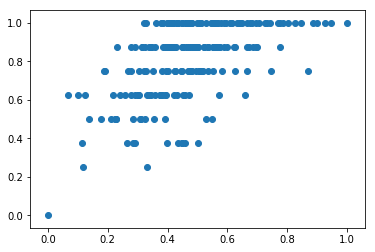

In [223]:
plt.scatter(merged["Ave"],merged["Ave_R"])

# Naive Bayes Classification 

Here we use the Naive Bayes Classification we learned in class from problem set 2 that trains based on initial positive and negative reviews to identify within our collected data whether certain reviews are negative, positive, or neutral. The reason we are trying naive based classification (in addition to TextBlob built in package) is to see whether there is a difference in how the two classify reviews.

In [224]:
letter_pattern = re.compile("[A-Za-z']+")
pos_words_counter = collections.Counter()
num_pos_revs= 0

neg_words_counter = collections.Counter()
num_neg_revs= 0

with open("positive.txt") as file: 
    for line in file.readlines():
        pos_words_counter.update(letter_pattern.findall(line))
        num_pos_revs +=1

with open("negative.txt") as file: 
    for line in file.readlines():
        neg_words_counter.update(letter_pattern.findall(line))
        num_neg_revs +=1

  

In [225]:
total_revs = num_pos_revs+num_neg_revs
prob_pos_rev = num_pos_revs/(total_revs)
prob_neg_rev = num_neg_revs/(total_revs)

positive_tokens=sum(pos_words_counter.values())
negative_tokens= sum(neg_words_counter.values())


In [226]:
def word_prob(word,counter,summation):
    word_occurence = counter[word]
    return word_occurence/summation

In [227]:
def review_prob(sentence,counter,summation):
    total_prob = 1
    letter_pattern = re.compile("[A-Za-z']+")
    sentence_to_words = letter_pattern.findall(sentence)
    print(sentence_to_words)
    for word in  sentence_to_words:
        total_prob =total_prob*word_prob(word,counter,summation)
    return total_prob

In [228]:
def word_log_prob(word,counter,summation):
    word_occurence = counter[word]
    p = word_occurence/summation
    return log(p)

def review_log_prob(sentence,counter,summation):
    total_prob = 0
    letter_pattern = re.compile("[A-Za-z']+")
    sentence_to_words = letter_pattern.findall(sentence)
    print(sentence_to_words)
    for word in  sentence_to_words:
        
        total_prob =total_prob+word_log_prob(word,counter,summation)
    return total_prob

In [229]:
both_counts = pos_words_counter+neg_words_counter
both_tokens =  positive_tokens+negative_tokens
vocabulary_size = len(both_counts)


In [230]:
def smoothed_word_log_prob(word, counter, sum_of_the_counter):
    word_occurence = counter[word]+1
    sum_of_the_counter = sum_of_the_counter+ vocabulary_size# +1 for each unique word?
    p = word_occurence/sum_of_the_counter
    return(log(p))

In [231]:
def smoothed_sentence_log_prob(sentence,counter,summation):
    total_prob = 0
    letter_pattern = re.compile("[A-Za-z']+")
    sentence_to_words = letter_pattern.findall(sentence)
    print(sentence_to_words)
    for word in  sentence_to_words:
        total_prob =total_prob+smoothed_word_log_prob(word,counter,summation)
    return total_prob

def ratio(sentence, counter, sum_of_the_counter,prob_of_rev):
   # P(w1,w2,etc.|pos)*P(pos)
    p_words_given_rev = smoothed_sentence_log_prob(sentence,counter,sum_of_the_counter)+log(prob_of_rev)
    return p_words_given_rev
    # P(w1,w2,etc.|pos)*P(pos)
    #p_words_given_neg =smoothed_sentence_log_prob(sentence,counter,sum_of_the_counter)*log(prob_neg_rev)  




In [232]:
yelp_data_upstate.head()

Date  Rating                                             Review  \
147 2018-07-09     5.0  Pricey, but excellent food and service. The dr...   
148 2018-07-05     4.0  Consistent. Great atmosphere and fun for group...   
149 2018-07-05     5.0  Came here for French Restaurant Week, and the ...   
150 2018-07-05     2.0  Boucherie had a great ambiance and service. Ov...   
151 2018-07-04     5.0  Great service, Very accommodating! Excellent m...   

          Temp  Sentiment  
147  13.729167   0.500000  
148  22.372727   0.212500  
149  22.372727   0.380000  
150  22.372727   0.405556  
151  22.665625   0.740000

In [233]:
result = pd.concat([yelp_data, yelp_data_upstate])
result.head()

Count       Date  NBC_sentiment  Rating  \
69   16.0 2018-07-09      13.932368     5.0   
70  158.0 2018-07-07      65.532072     5.0   
71   37.0 2018-07-07       3.516485     5.0   
72  110.0 2018-07-06      27.370330     5.0   
73  125.0 2018-07-06      -9.222927     2.0   

                                               Review  Sentiment       Temp  
69  Great place to enjoy great company with excell...   0.700000  13.729167  
70  This was one of my favorite tasting menu exper...   0.467130   8.466667  
71  Not much else to add beyond the glowing review...   0.100000   8.466667  
72  Great place to splurge or celebrate a special ...   0.257540  21.191304  
73  I've been to a lot of fine dining restaurants ...  -0.016875  21.191304

In [234]:
NBC_sentiment_list = []
for review in result['Review']: 
    pos_ratio = ratio(review,pos_words_counter,positive_tokens,prob_pos_rev)
    neg_ratio =  ratio(review,neg_words_counter,negative_tokens,prob_neg_rev)   
    NBC_sentiment_list.append(pos_ratio-neg_ratio)

for sent in NBC_sentiment_list:
    result["NBC_sentiment"] = [i for i in NBC_sentiment_list]


['Great', 'place', 'to', 'enjoy', 'great', 'company', 'with', 'excellent', 'food', 'Really', 'enjoyed', 'the', 'art', 'the', 'chef', 'prepared']
['Great', 'place', 'to', 'enjoy', 'great', 'company', 'with', 'excellent', 'food', 'Really', 'enjoyed', 'the', 'art', 'the', 'chef', 'prepared']
['This', 'was', 'one', 'of', 'my', 'favorite', 'tasting', 'menu', 'experiences', 'It', 'was', 'fancy', 'but', 'still', 'managed', 'to', 'feel', 'upbeat', 'and', 'relaxed', 'Everything', 'we', 'had', 'was', 'delicious', 'and', 'unique', 'The', 'staff', 'was', 'fun', 'and', 'the', 'presentation', 'of', 'everything', 'was', 'incredible', 'Not', 'to', 'mention', 'we', 'were', 'sent', 'away', 'with', 'a', 'tin', 'that', 'we', 'ate', 'out', 'of', 'earlier', 'full', 'of', 'our', 'menu', 'and', 'a', 'big', 'jar', 'of', 'granola', 'for', 'breakfast', 'My', 'absolute', 'favorites', 'of', 'the', 'night', 'were', 'the', 'egg', 'salad', 'asparagus', 'and', 'snow', 'pea', 'fish', 'egg', 'starters', 'the', 'bread', 

['Before', 'I', 'start', 'I', 'want', 'to', 'put', 'out', 'there', 'that', 'I', 'consider', 'myself', 'a', 'foodie', 'I', 'have', 'been', 'to', 'French', 'Laundy', 'Daniel', 'La', 'Bernadine', 'Del', 'Posto', 'Nomad', 'Gagan', 'in', 'Bangkok', 'etc', 'I', 'experienced', 'Madison', 'Park', 'first', 'many', 'years', 'ago', 'and', 'it', 'stayed', 'with', 'me', 'as', 'an', 'amazing', 'experience', 'We', 'had', 'dinner', 'April', 'and', "I've", 'toyed', 'with', 'weather', 'I', 'should', 'write', 'this', 'review', 'My', 'recent', 'trip', 'there', 'was', 'a', 'huge', 'disappointment', 'at', 'best', 'I', 'bought', 'this', 'as', 'an', 'engagement', 'gift', 'for', 'my', 'fianc', 'For', 'the', 'hype', 'best', 'in', 'the', 'world', 'and', 'the', 'price', 'I', 'was', 'so', 'excited', 'to', 'take', 'him', 'as', "he's", 'never', 'been', 'I', 'talked', 'it', 'up', 'so', 'much', 'The', 'new', 'dining', 'room', 'is', 'pretty', 'and', 'nice', 'bar', 'The', 'service', 'was', 'good', 'nothing', 'stellar', 

['Perfect', 'ambiance', 'beautiful', 'interiors', 'and', 'amazing', 'food', 'and', 'staff', 'Very', 'attentive', 'servers', 'and', 'beautifully', 'composed', 'dishes', 'Defenitelt', 'recommend']
['I', 'came', 'here', 'for', 'a', 'yelp', 'event', 'at', 'the', 'end', 'of', 'last', 'year', 'which', 'was', 'one', 'of', 'the', 'best', "I've", 'been', 'to', 'and', 'was', 'then', 'invited', 'back', 'for', 'a', 'dinner', 'The', 'food', 'here', 'is', 'excellent', 'I', 'started', 'with', 'the', 'foie', 'gras', 'which', 'was', 'amazing', 'and', 'a', 'wonderful', 'combination', 'of', 'sweet', 'and', 'savory', 'I', 'then', 'had', 'the', 'filet', 'mignon', 'with', 'truffle', 'butter', 'and', 'a', 'side', 'of', 'fries', 'and', 'both', 'were', 'delicious', 'I', 'finished', 'my', 'meal', 'with', 'the', 'pistachio', 'bombe', 'glacee', 'which', 'had', 'a', 'rich', 'fudge', 'sauce', 'on', 'top', 'and', 'was', 'great', 'to', 'share', 'The', 'restaurant', 'is', 'quite', 'large', 'but', 'was', 'very', 'crowd

In [235]:
len(NBC_sentiment_list)


523

Made assumption based on Textblob polarity distribution seen earlier, which showed to be normally distributed, that we can split the thresholds into 3 categories directly by dividing the reviews in 1/3.
Which is 170/3 = 57
Such that, when sorting based on NBC_sentiment in descensing order, top 0-60 are pos, 60-121 are neutral, and 121-170 are neg.

In [236]:
sort_by_nbcsent_descending = result.sort_values("NBC_sentiment",ascending=False)

sort_by_nbcsent_descending.head()

Count       Date  NBC_sentiment  Rating  \
484    NaN 2017-10-08     165.395881     5.0   
385    NaN 2018-01-05     143.567123     5.0   
483    NaN 2017-10-11     135.711254     4.0   
156  928.0 2018-03-05     132.984881     4.0   
366    NaN 2018-01-28     132.473228     5.0   

                                                Review  Sentiment       Temp  
484  As the French would say, everything was parfai...   0.248973  21.400000  
385  I initially went to Boucherie as part of a Yel...   0.323004 -21.025000  
483  The decor of this place is gorgeous! It is a p...   0.327140  14.778571  
156  So this restaurant is definitely up there in m...   0.232251  -5.233333  
366  This was my second time at Boucherie, and give...   0.248309   5.623077

Here a new column is added into the dataset based on the thresholds which assign the label based on the data sorted based on NBC_sentiment in descending order and split into 3. 1 being positive, 0 being neutral, and -1 being negative.

In [241]:
sort_by_nbcsent_descending["label"] = ["none"] * 523
sort_by_nbcsent_descending.head()
sort_by_nbcsent_descending["label"][0:174] =[1 for i in sort_by_nbcsent_descending.iloc[0:174]["NBC_sentiment"]]
sort_by_nbcsent_descending["label"][174:348] =[0 for i in sort_by_nbcsent_descending.iloc[174:348]["NBC_sentiment"]]
sort_by_nbcsent_descending["label"][348:523] =[-1 for i in sort_by_nbcsent_descending.iloc[348:523]["NBC_sentiment"]]
sort_by_nbcsent_descending.head()

Count       Date  NBC_sentiment  Rating  \
484    NaN 2017-10-08       1.000000    1.00   
385    NaN 2018-01-05       0.906399    1.00   
483    NaN 2017-10-11       0.872713    0.75   
156  928.0 2018-03-05       0.861023    0.75   
366    NaN 2018-01-28       0.858829    1.00   

                                                Review  Sentiment      Temp  \
484  As the French would say, everything was parfai...   0.248973  0.971032   
385  I initially went to Boucherie as part of a Yel...   0.323004  0.000000   
483  The decor of this place is gorgeous! It is a p...   0.327140  0.819479   
156  So this restaurant is definitely up there in m...   0.232251  0.361443   
366  This was my second time at Boucherie, and give...   0.248309  0.609927   

     label  
484      1  
385      1  
483      1  
156      1  
366      1

In [242]:
sort_by_nbcsent_descending["NBC_sentiment"] = minmax_scaling(sort_by_nbcsent_descending["NBC_sentiment"], columns = [0])
sort_by_nbcsent_descending["Rating"] = minmax_scaling(sort_by_nbcsent_descending["Rating"], columns = [0])
sort_by_nbcsent_descending["Temp"] = minmax_scaling(sort_by_nbcsent_descending["Temp"], columns = [0])
sort_by_nbcsent_descending["label"] = minmax_scaling(sort_by_nbcsent_descending["label"], columns = [0])


Here we are plotting all the two types of sentiment classification we have, with the produced label (1/pos,0/neut,-1/neg) , and the rating so to see whether there are correlations between the polarity of the review and the rating.

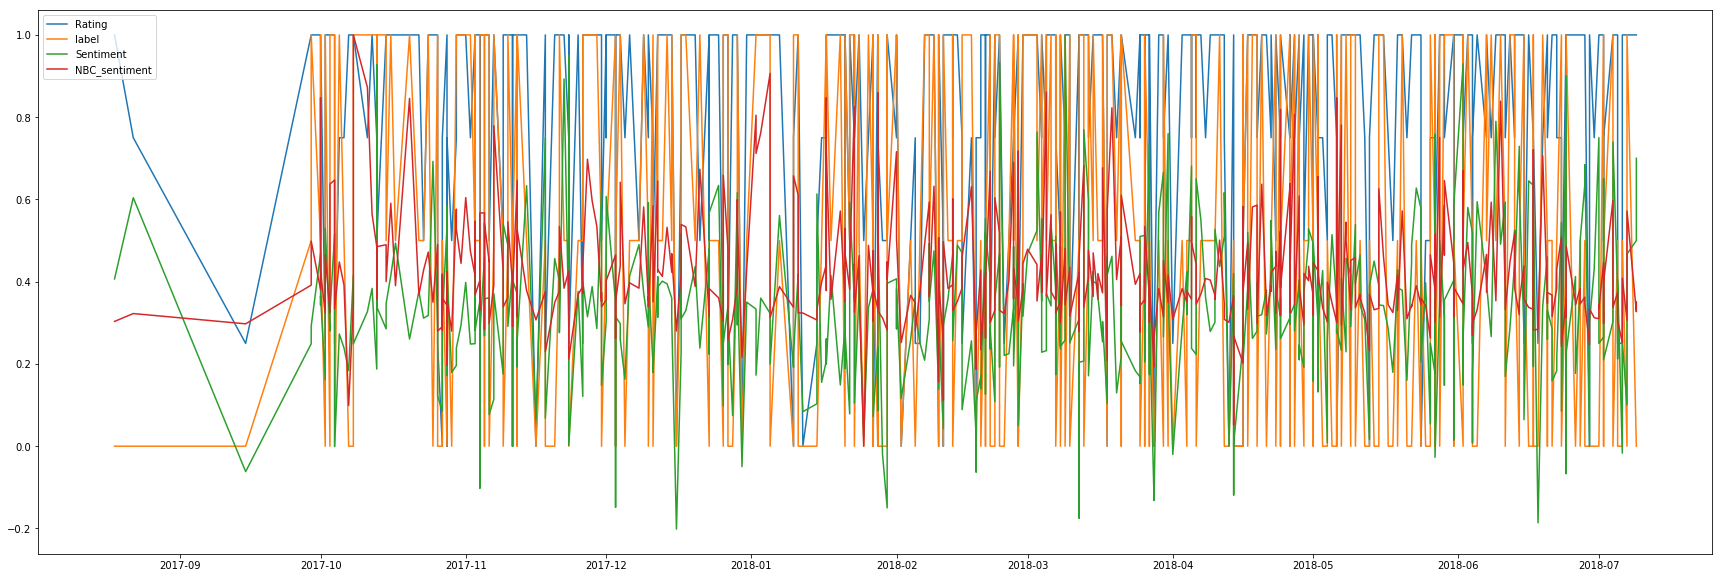

In [243]:
fig, ax = plt.subplots(figsize = (30,10))
sort_by_nbcsent_descending_2 = sort_by_nbcsent_descending.sort_values("Date",ascending=True)

plt.plot(sort_by_nbcsent_descending_2['Date'],sort_by_nbcsent_descending_2['Rating'])
plt.plot(sort_by_nbcsent_descending_2['Date'],sort_by_nbcsent_descending_2['label'])
plt.plot(sort_by_nbcsent_descending_2['Date'],sort_by_nbcsent_descending_2['Sentiment'])
plt.plot(sort_by_nbcsent_descending_2['Date'],sort_by_nbcsent_descending_2['NBC_sentiment'])
plt.legend(loc='upper left')


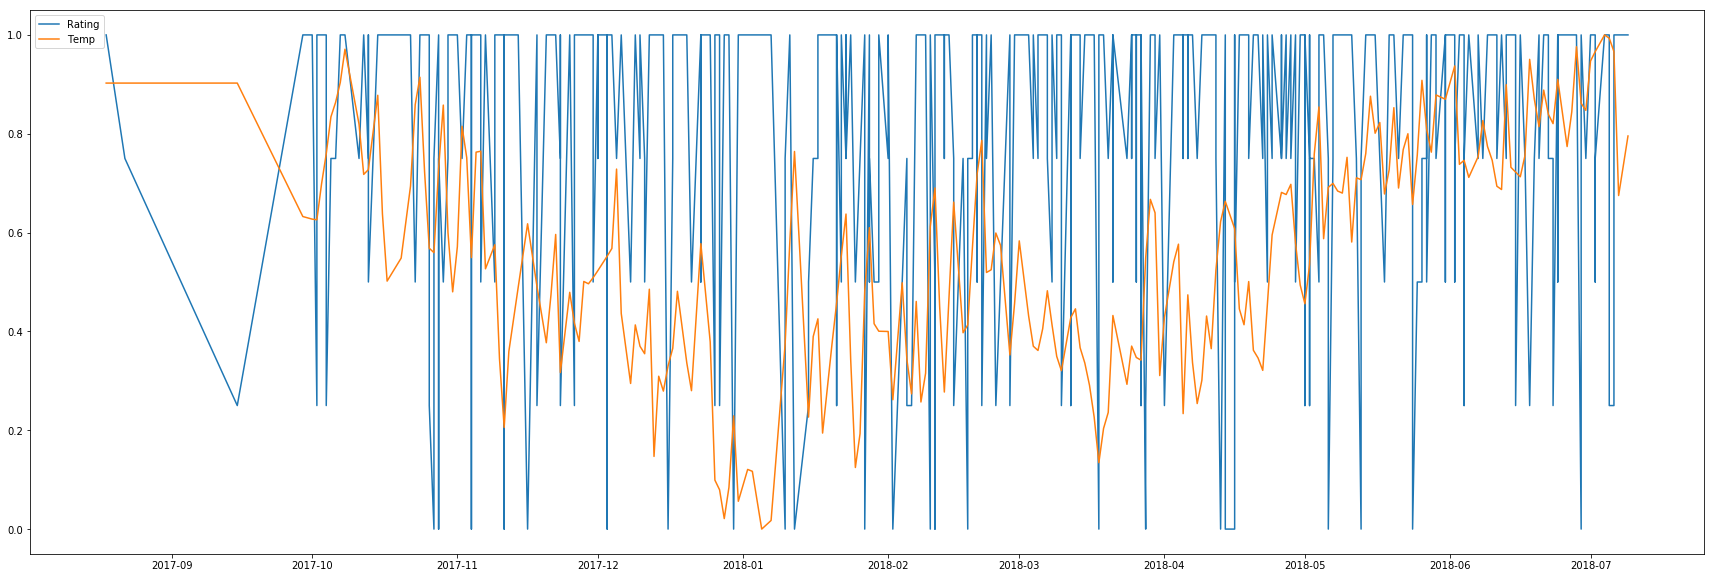

In [248]:
fig, ax = plt.subplots(figsize = (30,10))
sort_by_nbcsent_descending_2 = sort_by_nbcsent_descending.sort_values("Date",ascending=True)

plt.plot(sort_by_nbcsent_descending_2['Date'],sort_by_nbcsent_descending_2['Rating'])
# plt.plot(sort_by_nbcsent_descending_2['Date'],sort_by_nbcsent_descending_2['Sentiment'])
# plt.plot(sort_by_nbcsent_descending_2['Date'],sort_by_nbcsent_descending_2['NBC_sentiment'])
plt.plot(sort_by_nbcsent_descending_2['Date'],sort_by_nbcsent_descending_2['Temp'])

plt.legend(loc='upper left')

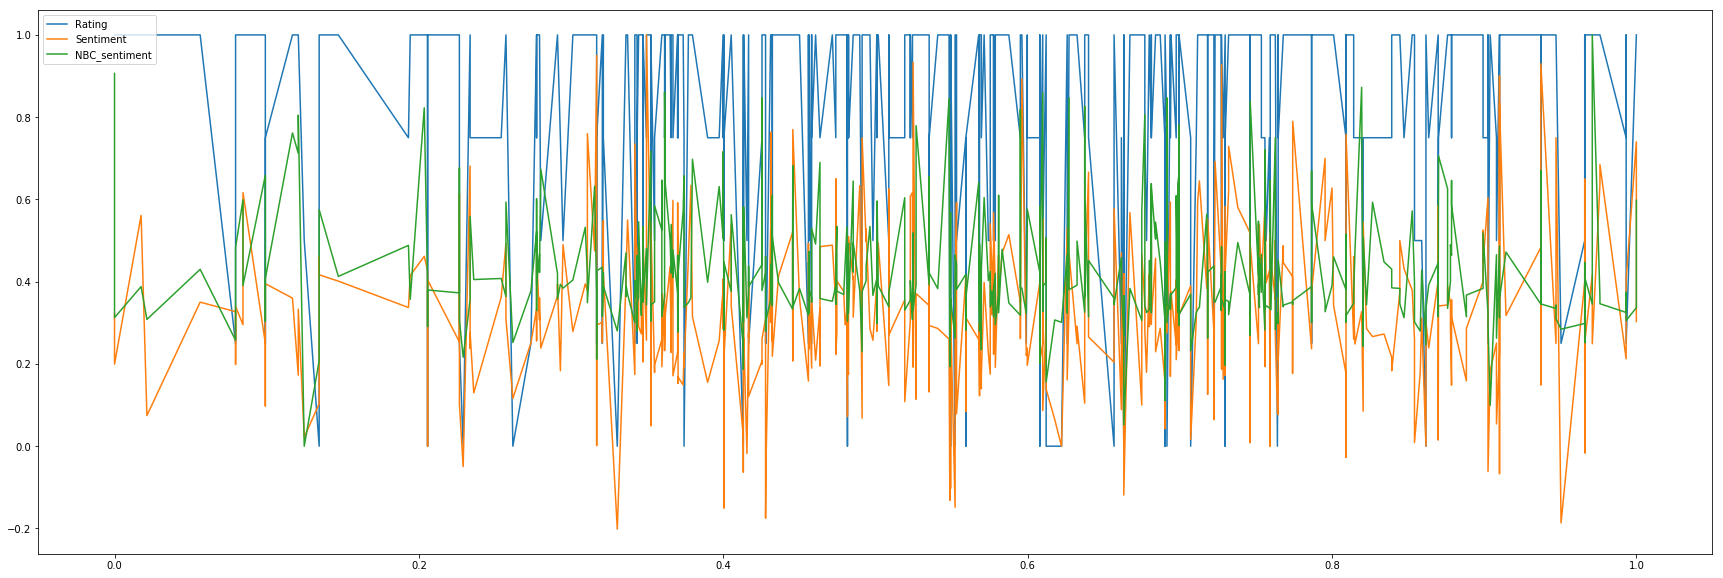

In [247]:
fig, ax = plt.subplots(figsize = (30,10))
sort_by_nbcsent_descending_2 = sort_by_nbcsent_descending.sort_values("Temp",ascending=True)

plt.plot(sort_by_nbcsent_descending_2['Temp'],sort_by_nbcsent_descending_2['Rating'])
# plt.plot(sort_by_nbcsent_descending_2['Date'],sort_by_nbcsent_descending_2['label'])
plt.plot(sort_by_nbcsent_descending_2['Temp'],sort_by_nbcsent_descending_2['Sentiment'])
plt.plot(sort_by_nbcsent_descending_2['Temp'],sort_by_nbcsent_descending_2['NBC_sentiment'])
plt.legend(loc='upper left')

